In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13, 7)

In [ ]:
folder = 'data/'
# filename = 'data/homing_issue_data.txt'
# filename = 'data/homing_finger0_data.txt'
# filename = 'data/homing_finger1_data.txt'
# filename = 'data/homing_finger2_data.txt'
# filename = 'data/homing_assign_cpu_to_thread.txt'
# filename = 'data/homing_can_investigate.txt'
# filename = 'data/homing_issue_after_cpu_affinity.txt'
# filename = 'data/homing_issue_after_cpu_affinity_sched_rr.txt'
# filename = 'data/homing_3_fingers_rt_patch.txt'
# filename = 'data/homing_2_fingers_rt_patch.txt'
# filename = 'data/homing_2_fingers_rt_patch_bigger_gain.txt'
# filename = 'data/homing_data_finger1_with_buffer_index.txt'
# filename = 'data/homing_data_finger2_with_buffer_index.txt'
# filename = 'data/homing_3_fingers_c-states_cpu_freq_scaling.txt'
# filename = 'data/homing_3_fingers_c-states_cpu_freq_scaling_second_trial.txt'
# filename = 'data/homing_3_fingers_c-states_cpu_freq_scaling_third_trial.txt'
# filename = 'data/homing_3_fingers_c-states_cpu_freq_scaling_fourth_trial.txt'
# filename = 'data/homing_3_fingers_c-states_cpu_freq_scaling_process_high_priority.txt'
# filename = 'data/homing_3_fingers_c-states_cpu_freq_scaling_process_high_priority_second_trial.txt'
# filename = 'data/homing_2_fingers_can45_first.txt'
# filename = 'data/homing_3_fingers_can45_first_add_measured_torque.txt'
# filename = 'homing_candump-2024-07-29_100824.txt'
# filename = 'data/homing_after_shield_can23.txt'
# filename = 'data/homing_after_shield_can23_second_trial.txt'
# filename = 'data/homing_after_shield_can2345.txt'
# filename = 'data/homing_after_shield_can2345_second_trial.txt'
# filename = 'data/homing_candump-2024-07-29_122130_swap_can45_can01.txt'
# filename = 'homing_candump-2024-07-29_125711.txt'
# filename = 'homing_candump-2024-07-29_131713.txt'
# filename = 'homing_candump-2024-08-02_140308.txt'
# filename = 'homing_usb_can.txt'
# filename = 'homing_candump-2024-08-05_112950.txt'
filename = 'homing_candump-2024-08-05_114419.txt'

filepath = folder + filename

raw_data = np.loadtxt(filepath, delimiter=',', skiprows=0, dtype=str)
data = {}
num_joints = 6

for i in range(num_joints):
    data[f"joint id: {i}"] = {"measured_angle": [], "target_angle": [], "newest_measurement_index": [], "set_torque": [], "measured_torque": []}
    
for row in raw_data:
    measured_angle = float(row[1].split(" ")[-1])
    target_angle = float(row[2].split(" ")[-1])
    data[row[0]]["measured_angle"].append(measured_angle)
    data[row[0]]["target_angle"].append(target_angle)

    if row.shape[0] == 4:
        newest_measurement_index = int(row[3].split(" ")[-1])
        data[row[0]]["newest_measurement_index"].append(newest_measurement_index)
        
    if row.shape[0] == 5:
        newest_measurement_index = int(row[3].split(" ")[-1])
        set_torque = float(row[4].split(" ")[-1])
        data[row[0]]["newest_measurement_index"].append(newest_measurement_index)
        data[row[0]]["set_torque"].append(set_torque)
        
    if row.shape[0] == 6:
        newest_measurement_index = int(row[3].split(" ")[-1])
        set_torque = float(row[4].split(" ")[-1])
        measured_torque = float(row[5].split(" ")[-1])
        data[row[0]]["newest_measurement_index"].append(newest_measurement_index)
        data[row[0]]["set_torque"].append(set_torque)
        data[row[0]]["measured_torque"].append(measured_torque)



In [ ]:
%matplotlib widget
fig, ax = plt.subplots(3, 3)

for i in range(num_joints):
    ax[i//3, i%3].plot(data[f"joint id: {i}"]["measured_angle"], c="b")
    ax[i//3, i%3].plot(data[f"joint id: {i}"]["target_angle"], c="r")
    ax[i//3, i%3].plot(np.abs(np.array(data[f"joint id: {i}"]["target_angle"]) - np.array(data[f"joint id: {i}"]["measured_angle"])), c="g")
    ax[i//3, i%3].legend(["measured angle", "target angle"])
    ax[i//3, i%3].set_title(f"joint id: {i}")
plt.tight_layout()
plt.savefig(f'images/{filename}_measurement.png', dpi=600)

In [ ]:
fig, ax = plt.subplots(3, 3)

for i in range(num_joints):
    ax[i//3, i%3].plot(data[f"joint id: {i}"]["newest_measurement_index"])
    ax[i//3, i%3].set_title(f"joint id: {i}")
plt.suptitle("Newest measurement index for all joints")
plt.tight_layout()
plt.savefig(f'images/{filename}_measurement_buffer.png', dpi=600)

## candump is a useful tool to monitor send/receive CAN frames with logging feature.

In [ ]:
# analyze CAN dump result
# candump_file = 'data/candump-2024-07-29_100824.log'
# candump_file = 'data/candump-2024-07-29_122130.log'
# candump_file = 'data/candump-2024-07-29_125711.log'
# candump_file = 'data/candump-2024-07-29_131713.log'
# candump_file = 'data/candump-2024-08-02_140308.log'
# candump_file = 'data/candump-2024-08-05_110151.log'
# candump_file = 'data/candump-2024-08-05_112950.log'
candump_file = 'data/candump-2024-08-05_114419.log'
can_data = {}
num_joints = 6

for i in range(num_joints):
    can_data[f"can{i}"] = {"timestamp": [], "sent_torque_motor_1": [], "sent_torque_motor_2": []}
    
def hex_to_signed_32bit_decimal(hex_str):
    # Convert the hexadecimal string to a 32-bit integer
    num = int(hex_str, 16)

    # If the number is greater than 2^31 - 1, it is a negative number
    if num >= 0x80000000:
        num -= 0x100000000

    return num

with open(candump_file, 'r') as f:
    for line in f:
        row = line.split(" ")
        if len(row) > 3:
            continue
        timestamp = float(row[0][1:-1])
        can_interface = row[1]
        can_frame_data = (row[2].rstrip("\n").split("#"))[1]
        can_data[can_interface]["timestamp"].append(timestamp)
        can_data[can_interface]["sent_torque_motor_1"].append(hex_to_signed_32bit_decimal(can_frame_data[:8]) / (2**24) * 0.18)
        can_data[can_interface]["sent_torque_motor_2"].append(hex_to_signed_32bit_decimal(can_frame_data[8:]) / (2**24) * 0.18)

In [ ]:
fig, ax = plt.subplots(3, 3)
mapping_joint_id_can_interface = {
    0: "can1", 1: "can0", 2: "can0",
    3: "can3", 4: "can2", 5: "can2",
    6: "can5", 7: "can4", 8: "can4",
}

mapping_joint_id_motor_id = {
    0: "1", 1: "1", 2: "2",
    3: "1", 4: "1", 5: "2",
    6: "1", 7: "1", 8: "2",
}
for i in range(num_joints):
    can_id = mapping_joint_id_can_interface[i]
    motor_id = mapping_joint_id_motor_id[i]
    ax[i//3, i%3].plot(data[f"joint id: {i}"]["set_torque"])
    ax[i//3, i%3].plot(data[f"joint id: {i}"]["measured_torque"])
    # ax[i//3, i%3].scatter(can_data[can_id]["timestamp"][2:], can_data[can_id][f"sent_torque_motor_{motor_id}"][2:])
    ax[i//3, i%3].plot(can_data[can_id][f"sent_torque_motor_{motor_id}"][2:])
    ax[i//3, i%3].legend(["commanded_torque", "measured_torque", "commanded_torque_candump"])
    ax[i//3, i%3].set_title(f"joint id: {i}")
plt.suptitle("Commanded torque for all joints")
plt.tight_layout()
plt.savefig(f'images/{filename}_torque.png', dpi=600)

In [ ]:
fig, ax = plt.subplots(3, 3)
for i in range(num_joints):
    can_id = mapping_joint_id_can_interface[i]
    motor_id = mapping_joint_id_motor_id[i]
    # ax[i//3, i%3].scatter((np.array(can_data[can_id]["timestamp"][2:]) - can_data[can_id]["timestamp"][2]) * 1000, can_data[can_id][f"sent_torque_motor_{motor_id}"][2:], s=3)
    ax[i//3, i%3].scatter(can_data[can_id]["timestamp"][2:], can_data[can_id][f"sent_torque_motor_{motor_id}"][2:], s=3)
    ax[i//3, i%3].set_title(f"joint id: {i}")
    ax[i//3, i%3].set_xlabel("Time (ms)")
    ax[i//3, i%3].set_ylabel("Torque (Nm)")
plt.suptitle("Commanded torque for all joints vs timestamp")
plt.tight_layout()
plt.savefig(f'images/{filename}_sent_torque_vs_timestamp.png', dpi=600)

In [11]:
candump_file = 'data/debug_can_usb_device/candump-2024-08-06_124131.log'
# candump_file = 'data/debug_can_usb_device/candump-2024-08-06_130610.log'
# candump_file = 'data/debug_can_usb_device/candump-2024-08-06_132659.log'
# candump_file = 'data/debug_can_usb_device/candump-2024-08-06_133239.log'
# candump_file = 'data/debug_can_usb_device/candump-2024-08-06_135245.log'
# candump_file = 'data/debug_can_usb_device/candump-2024-08-06_135828.log'
can_data = {"can0": [], "can1": []}

with open(candump_file, 'r') as f:
    for line in f:
        row = line.split(" ")
        if len(row) > 3:
            continue
        timestamp = float(row[0][1:-1])
        can_interface = row[1]
        can_frame_data = (row[2].rstrip("\n").split("#"))[1]
        (can_data[can_interface]).append(timestamp)

In [2]:
# plt.scatter(range(len(can_data["can0"])), (np.array(can_data["can0"]) - can_data["can0"][0]) * 1000, s=1)

In [12]:
%matplotlib widget
intervals = (np.array(can_data["can0"][3:]) - np.array(can_data["can0"][2:-1])) * 1000
# plt.plot(intervals)

In [13]:
intervals.mean()

1.0145072265782198

In [14]:
intervals.max()

1.2221336364746094

In [15]:
intervals.min()

0.8342266082763672

In [16]:
intervals.argmax()

18015

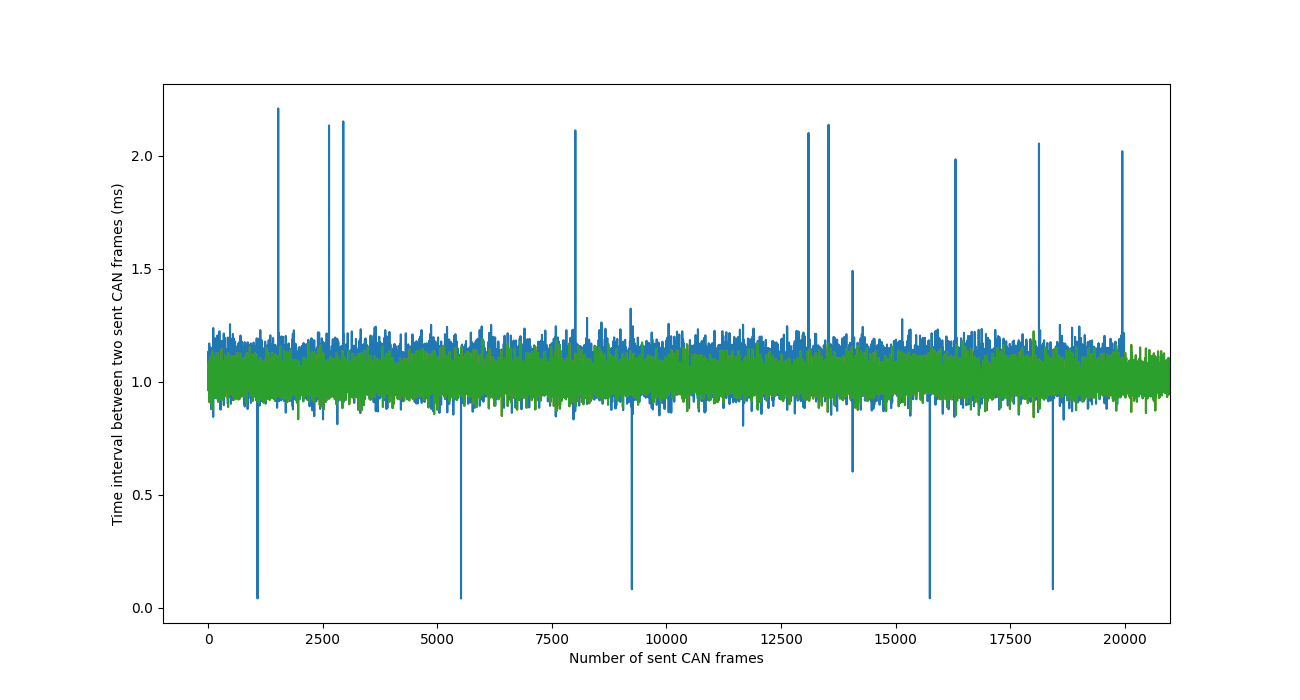

In [18]:
plt.plot(intervals)
plt.xlabel("Number of sent CAN frames")
plt.ylabel("Time interval between two sent CAN frames (ms)")
plt.show()
# plt.savefig("images/time_interval.png", dpi=600)